In [5]:
###Packages
import pandas as pd
import parse
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
####PLOT ALL LEARNING CURVES FOR PRETRAIN

/tmp/ipykernel_219392/1948776806.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_219392/1948776806.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_219392/1948776806.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

AttributeError: 'DataFrame' object has no attribute 'append'

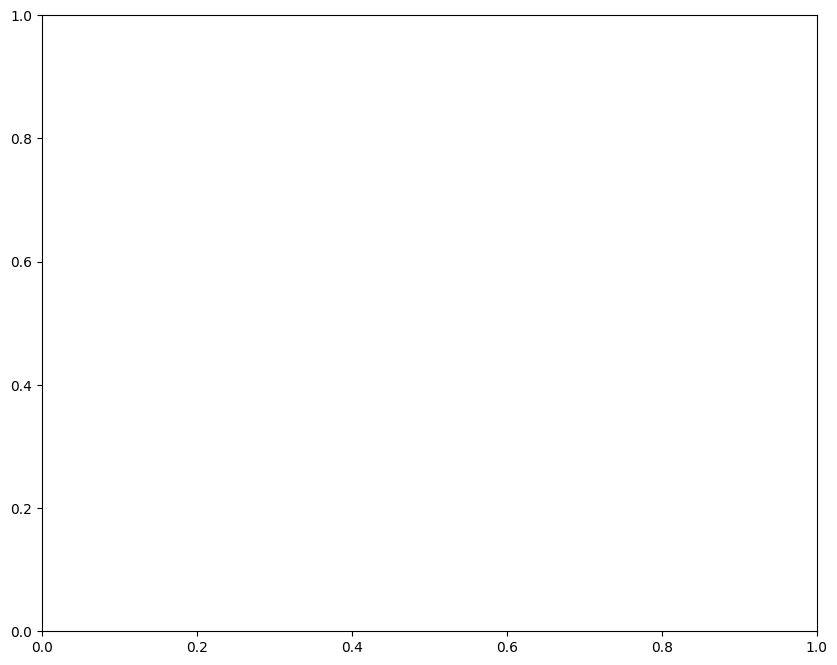

In [7]:
####PRETRAIN
def parse_pretrain_stimuli (stimulus):
    stimulus_parser = parse.compile("{foreground}_{sdB:d}")
    parse_result = stimulus_parser.parse(stimulus)
    singlemotif = parse_result.named['foreground']
    sdB = parse_result.named['sdB']
    SNR = 70
    return singlemotif, sdB, SNR

full_responses = pd.DataFrame()
pretrain_plotting_table = pd.DataFrame()
figure, ax = plt.subplots(figsize=(10, 8))
birds = ['C269','C280','C291', 'C235', 'C293', 'C294','C250', 'C193', 'C191']
rearing = ['CR', 'PR']
leg = {'CR': 'black', 'PR': 'blue'}
binsize = 100
for idx, i in enumerate(birds):
    fulldf = pd.read_csv (i+'.csv')
    mask = fulldf['experiment'].str.contains('pretrain|shaping')
    data = fulldf[mask]
    data = data[data['lights'].isna()]
    smalldf = data[['subject','correct','response','stimulus', 'correction', 'time']]
    SNRdict = smalldf
    motif = []
    sdB = []
    SNR = []
    for i in SNRdict['stimulus']:
        info = list(parse_pretrain_stimuli(i))
        motif.append(info[0])
        sdB.append(info[1])
        SNR.append(info[2])

    SNRdict['Motif'] = motif
    SNRdict['sdB'] = sdB
    SNRdict['SNR'] = SNR
    
    tracker = True
    SNRdict['FIRST_TRY']=0
    for index, trial  in SNRdict[::-1].iterrows(): # This condition has to come first:
        if trial.correction == 0:
            tracker = True
    # So that these can be evaluated correctly
        if (trial['correction']==0) & (trial['response']!='timeout') & (trial['response']!= 'peck_center'):
            SNRdict.loc[index, 'FIRST_TRY'] = 1
            tracker = False
        if (trial['correction']!=0) & (trial['response']!='timeout') & (trial['response']!= 'peck_center')& tracker:
            SNRdict.loc[index, 'FIRST_TRY'] = 1
            tracker = False           
    Firsttrialdict = SNRdict[SNRdict.FIRST_TRY == 1]
    response = Firsttrialdict[Firsttrialdict.response != 'timeout'].reset_index()
    full_responses = full_responses.append(response)
# ####Add rearing and location data to dataframe. Remove all noise SNRs and silence foreground
bird_metadata = pd.read_csv('behavior_metadata.csv')
Responsedict = full_responses.merge(bird_metadata)
##Create Dataframe that contains percent correct across SNR###
subjects = Responsedict['subject'].unique()
for s in subjects:
    prac_df = Responsedict[Responsedict['subject']==s]
    wonkybin = len(prac_df)%binsize
    num_bins = len(prac_df)//binsize
    count = []
    numcorrect = []
    wonkybinneddata = prac_df.iloc[0:wonkybin]
    trialcount = len(wonkybinneddata.SNR)
    num = len(wonkybinneddata[wonkybinneddata.correct==True])
    count.append(trialcount)
    numcorrect.append(num)

    for i in range(num_bins):
        binneddata = prac_df.iloc[wonkybin+(i)*binsize:wonkybin+(i+1)*binsize]
        trialcount = len(binneddata.SNR)
        num = len(binneddata[binneddata.correct==True])
        count.append(trialcount)
        numcorrect.append(num)

    count = count[::-1]
    numcorrect = numcorrect[::-1]
    analysis={'subject': s,
              'group': prac_df['group'].iloc[0],
              'bin':range(num_bins+1),
          'N':count,
          'Correct':numcorrect,
          }
    analysisdf = pd.DataFrame(analysis)
    analysisdf['PercentCorrect'] = analysisdf['Correct']/analysisdf['N']
    pretrain_plotting_table = pretrain_plotting_table.append(analysisdf)
    if analysisdf['group'].iloc[0] == 'CR':
        c = 'black'
    else:
        c = 'blue'
    plt.plot(analysisdf.bin, analysisdf.PercentCorrect, color = c, alpha = .4)
grouped_plots = pretrain_plotting_table.groupby(['group','bin'])['PercentCorrect'].agg('mean').reset_index()
CR_plot = grouped_plots[grouped_plots['group'] == 'CR']
PR_plot = grouped_plots[grouped_plots['group'] == 'PR']
plt.plot(CR_plot.bin, CR_plot.PercentCorrect, color = 'Black', linewidth = 5)
plt.plot(PR_plot.bin, PR_plot.PercentCorrect, color = 'Blue', linewidth = 5)
import matplotlib.lines as mlines
black_line = mlines.Line2D([], [], color='black', label='CR')
pink_line = mlines.Line2D([], [], color='blue',label='PR')
plt.legend(handles = [black_line,pink_line])
plt.xlabel('Bins (100 trials per bin)', fontsize = 12)
plt.ylabel('Percent Correct', fontsize = 12)
plt.title("Percent Correct Across Trials",fontsize = 14)
plt.savefig('Pretrain Performance Curves Across Rearing Condition')

/tmp/ipykernel_2104427/700860131.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_2104427/700860131.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_2104427/700860131.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

/tmp/ipykernel_2104427/700860131.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_responses = full_responses.append(response)
/tmp/ipykernel_2104427/700860131.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_2104427/700860131.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_2104427/700860131.py:35: SettingWithCopyWarning: 
A val

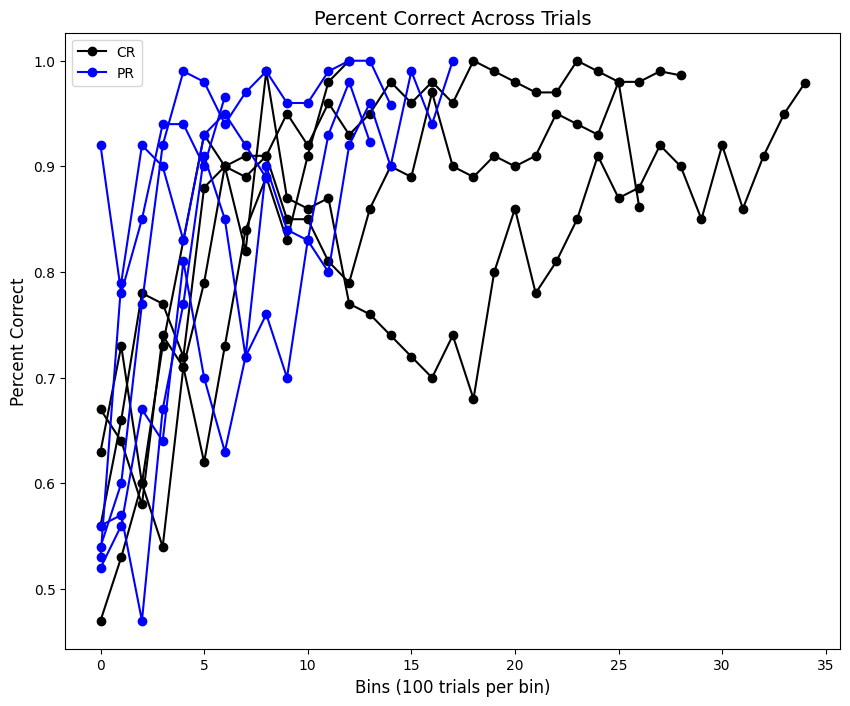

In [56]:
######INDIVIDUAL PRETRAIN PERCENT CORRECT
def parse_pretrain_stimuli (stimulus):
    stimulus_parser = parse.compile("{foreground}_{sdB:d}")
    parse_result = stimulus_parser.parse(stimulus)
    singlemotif = parse_result.named['foreground']
    sdB = parse_result.named['sdB']
    SNR = 70
    return singlemotif, sdB, SNR

full_responses = pd.DataFrame()
pretrain_plotting_table = pd.DataFrame()
figure, ax = plt.subplots(figsize=(10, 8))
birds = ['C269','C280','C291', 'C235', 'C293', 'C294','C250', 'C193', 'C191']
rearing = ['CR', 'PR']
leg = {'CR': 'black', 'PR': 'blue'}
binsize = 100
for idx, i in enumerate(birds):
    fulldf = pd.read_csv (i+'.csv')
    mask = fulldf['experiment'].str.contains('pretrain|shaping')
    data = fulldf[mask]
    data = data[data['lights'].isna()]
    smalldf = data[['subject','correct','response','stimulus', 'correction', 'time']]
    SNRdict = smalldf
    motif = []
    sdB = []
    SNR = []
    for i in SNRdict['stimulus']:
        info = list(parse_pretrain_stimuli(i))
        motif.append(info[0])
        sdB.append(info[1])
        SNR.append(info[2])

    SNRdict['Motif'] = motif
    SNRdict['sdB'] = sdB
    SNRdict['SNR'] = SNR
    
    tracker = True
    SNRdict['FIRST_TRY']=0
    for index, trial  in SNRdict[::-1].iterrows(): # This condition has to come first:
        if trial.correction == 0:
            tracker = True
    # So that these can be evaluated correctly
        if (trial['correction']==0) & (trial['response']!='timeout')& (trial['response']!= 'peck_center'):
            SNRdict.loc[index, 'FIRST_TRY'] = 1
            tracker = False
        if (trial['correction']!=0) & (trial['response']!='timeout') & (trial['response']!= 'peck_center')& tracker:
            SNRdict.loc[index, 'FIRST_TRY'] = 1
            tracker = False           
    Firsttrialdict = SNRdict[SNRdict.FIRST_TRY == 1]
    response = Firsttrialdict[Firsttrialdict.response != 'timeout'].reset_index()
    full_responses = full_responses.append(response)
# ####Add rearing and location data to dataframe. Remove all noise SNRs and silence foreground
bird_metadata = pd.read_csv('behavior_metadata.csv')
Responsedict = full_responses.merge(bird_metadata)
##Create Dataframe that contains percent correct across SNR###
subjects = Responsedict['subject'].unique()
for s in subjects:
    prac_df = Responsedict[Responsedict['subject']==s]
    wonkybin = len(prac_df)%binsize
    num_bins = len(prac_df)//binsize
    count = []
    numcorrect = []
    wonkybinneddata = prac_df.iloc[0:wonkybin]
    trialcount = len(wonkybinneddata.SNR)
    num = len(wonkybinneddata[wonkybinneddata.correct==True])
    count.append(trialcount)
    numcorrect.append(num)

    for i in range(num_bins):
        binneddata = prac_df.iloc[wonkybin+(i)*binsize:wonkybin+(i+1)*binsize]
        trialcount = len(binneddata.SNR)
        num = len(binneddata[binneddata.correct==True])
        count.append(trialcount)
        numcorrect.append(num)

    count = count[::-1]
    numcorrect = numcorrect[::-1]
    analysis={'subject': s,
              'group': prac_df['group'].iloc[0],
              'bin':range(num_bins+1),
          'N':count,
          'Correct':numcorrect,
          }
    analysisdf = pd.DataFrame(analysis)
    analysisdf['PercentCorrect'] = analysisdf['Correct']/analysisdf['N']
    pretrain_plotting_table = pretrain_plotting_table.append(analysisdf)
    if analysisdf['group'].iloc[0] == 'CR':
        c = 'black'
    else:
        c = 'blue'
    plt.plot(analysisdf.bin, analysisdf.PercentCorrect, color = c, marker= 'o')    
    plt.xlabel('Bins (100 trials per bin)', fontsize = 12)
    plt.ylabel('Percent Correct', fontsize = 12)
    plt.title("Percent Correct Across Trials",fontsize = 14)
    
    import matplotlib.lines as mlines
    black_line = mlines.Line2D([], [], color='black', marker='o',
                          markersize=6, label='CR')
    pink_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=6, label='PR')
    plt.legend(handles = [black_line,pink_line])
    plt.savefig('Individual Pretrain Performance Curves Across Rearing Condition')

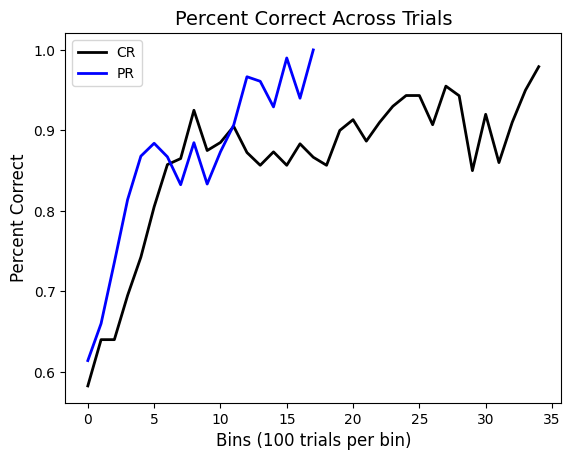

In [57]:
#####AVERAGE PRETRAIN
grouped_plots = pretrain_plotting_table.groupby(['group','bin'])['PercentCorrect'].agg('mean').reset_index()
CR_plot = grouped_plots[grouped_plots['group'] == 'CR']
PR_plot = grouped_plots[grouped_plots['group'] == 'PR']
fig, ax = plt.subplots()
ax1 = plt.plot(CR_plot.bin, CR_plot.PercentCorrect, color = 'Black', linewidth  = 2)
ax1 = plt.plot(PR_plot.bin, PR_plot.PercentCorrect, color = 'Blue', linewidth = 2)
plt.legend(['CR', 'PR'])
plt.xlabel('Bins (100 trials per bin)', fontsize = 12)
plt.ylabel('Percent Correct', fontsize = 12)
plt.title("Percent Correct Across Trials",fontsize = 14)
plt.savefig('Average Pretrain Performance Curves Across Rearing Condition')

In [ ]:
#####PLOT LEARNING CURVES FOR TRAINING DATA

/tmp/ipykernel_1959539/1390367950.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_1959539/1390367950.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_1959539/1390367950.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

/tmp/ipykernel_1959539/1390367950.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_responses = full_responses.append(Responsedict)
/tmp/ipykernel_1959539/1390367950.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_1959539/1390367950.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_1959539/1390367950.py:41: SettingWithCopyWarning

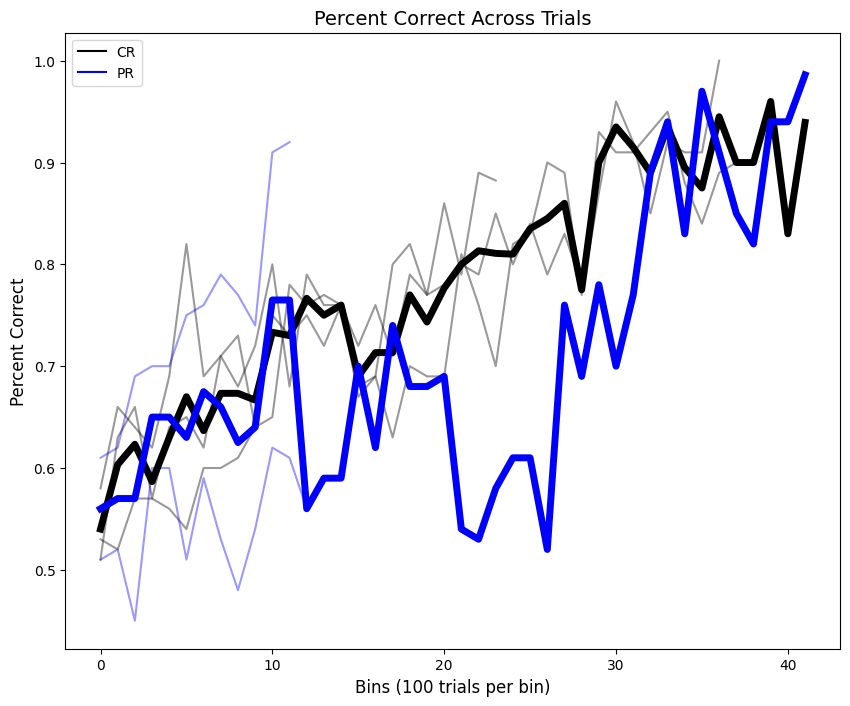

In [217]:
####TRAINING PERFORMANCE
def parse_stimuli (stimulus):
    stimulus_parser = parse.compile("{foreground}-{sdB:d}_{background}-{snl:d}")
    parse_result = stimulus_parser.parse(stimulus)
    singlemotif = parse_result.named['foreground']
    background = parse_result.named['background']
    sdB = parse_result.named['sdB']
    snl = parse_result.named['snl']
    SNR = snl - sdB
    return singlemotif, sdB, background, snl, SNR

training_plotting_table = pd.DataFrame()
full_responses = pd.DataFrame()
figure, ax = plt.subplots(figsize=(10, 8))
birds = ['C269','C280','C291','C293', 'C294']
rearing = ['CR', 'PR']
leg = {'CR': 'black', 'PR': 'blue'}
binsize = 100

for idx, i in enumerate(birds):
    fulldf = pd.read_csv (i+'.csv')
    mask = fulldf['experiment'].str.contains('training|segmented')
    data = fulldf[mask]
    data = data[data['lights'].isna()]
    smalldf = data[['subject','correct','response','stimulus', 'correction', 'time']]
    SNRdict = smalldf
    motif = []
    background = []
    sdB = []
    snl = []
    SNR = []
    for i in SNRdict['stimulus']:
        info = list(parse_stimuli(i))
        motif.append(info[0])
        sdB.append(info[1])
        background.append(info[2])
        snl.append(info[3])
        SNR.append(info[4])
    SNRdict['Motif'] = motif
    SNRdict['sdB'] = sdB
    SNRdict['Background'] = background
    SNRdict['snl'] = snl
    SNRdict['SNR'] = SNR
    tracker = True
    SNRdict['FIRST_TRY']=0
    for index, trial  in SNRdict[::-1].iterrows(): # This condition has to come first:
        if trial.correction == 0:
            tracker = True
    # So that these can be evaluated correctly
        if (trial['correction']==0) & (trial['response']!='timeout') & (trial['response']!= 'peck_center'):
            SNRdict.loc[index, 'FIRST_TRY'] = 1
            tracker = False
        if (trial['correction']!=0) & (trial['response']!='timeout') & (trial['response']!= 'peck_center')& tracker:
            SNRdict.loc[index, 'FIRST_TRY'] = 1
            tracker = False           
    Firsttrialdict = SNRdict[SNRdict.FIRST_TRY == 1]
    Responsedict = Firsttrialdict[Firsttrialdict.response != 'timeout'].reset_index()
    full_responses = full_responses.append(Responsedict)
# ####Add rearing and location data to dataframe. Remove all noise SNRs and silence foreground
bird_metadata = pd.read_csv('behavior_metadata.csv')
Responsedict = full_responses.merge(bird_metadata)
##Create Dataframe that contains percent correct across SNR###
subjects = Responsedict['subject'].unique()
for s in subjects:
    prac_df = Responsedict[Responsedict['subject']==s]
    wonkybin = len(prac_df)%binsize
    num_bins = len(prac_df)//binsize
    count = []
    numcorrect = []
    wonkybinneddata = prac_df.iloc[0:wonkybin]
    trialcount = len(wonkybinneddata.SNR)
    num = len(wonkybinneddata[wonkybinneddata.correct==True])
    count.append(trialcount)
    numcorrect.append(num)

    for i in range(num_bins):
        binneddata = prac_df.iloc[wonkybin+(i)*binsize:wonkybin+(i+1)*binsize]
        trialcount = len(binneddata.SNR)
        num = len(binneddata[binneddata.correct==True])
        count.append(trialcount)
        numcorrect.append(num)

    count = count[::-1]
    numcorrect = numcorrect[::-1]
    analysis={'subject': s,
              'group': prac_df['group'].iloc[0],
              'bin':range(num_bins+1),
          'N':count,
          'Correct':numcorrect,
          }
    analysisdf = pd.DataFrame(analysis)
    analysisdf['PercentCorrect'] = analysisdf['Correct']/analysisdf['N']
    training_plotting_table = training_plotting_table.append(analysisdf)
    if analysisdf['group'].iloc[0] == 'CR':
        c = 'black'
    else:
        c = 'blue'
    plt.plot(analysisdf.bin, analysisdf.PercentCorrect, color = c, alpha = .4)
grouped_plots = training_plotting_table.groupby(['group','bin'])['PercentCorrect'].agg('mean').reset_index()
CR_plot = grouped_plots[grouped_plots['group'] == 'CR']
PR_plot = grouped_plots[grouped_plots['group'] == 'PR']
plt.plot(CR_plot.bin, CR_plot.PercentCorrect, color = 'Black', linewidth = 5)
plt.plot(PR_plot.bin, PR_plot.PercentCorrect, color = 'Blue', linewidth = 5)
import matplotlib.lines as mlines
black_line = mlines.Line2D([], [], color='black', label='CR')
pink_line = mlines.Line2D([], [], color='blue',label='PR')
plt.legend(handles = [black_line,pink_line])
plt.xlabel('Bins (100 trials per bin)', fontsize = 12)
plt.ylabel('Percent Correct', fontsize = 12)
plt.title("Percent Correct Across Trials",fontsize = 14)
plt.savefig('Training Performance Curves Across Rearing Condition')

/tmp/ipykernel_1959539/389650022.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_1959539/389650022.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_1959539/389650022.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

/tmp/ipykernel_1959539/389650022.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_responses = full_responses.append(Responsedict)
/tmp/ipykernel_1959539/389650022.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_1959539/389650022.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_1959539/389650022.py:41: SettingWithCopyWarning: 
A

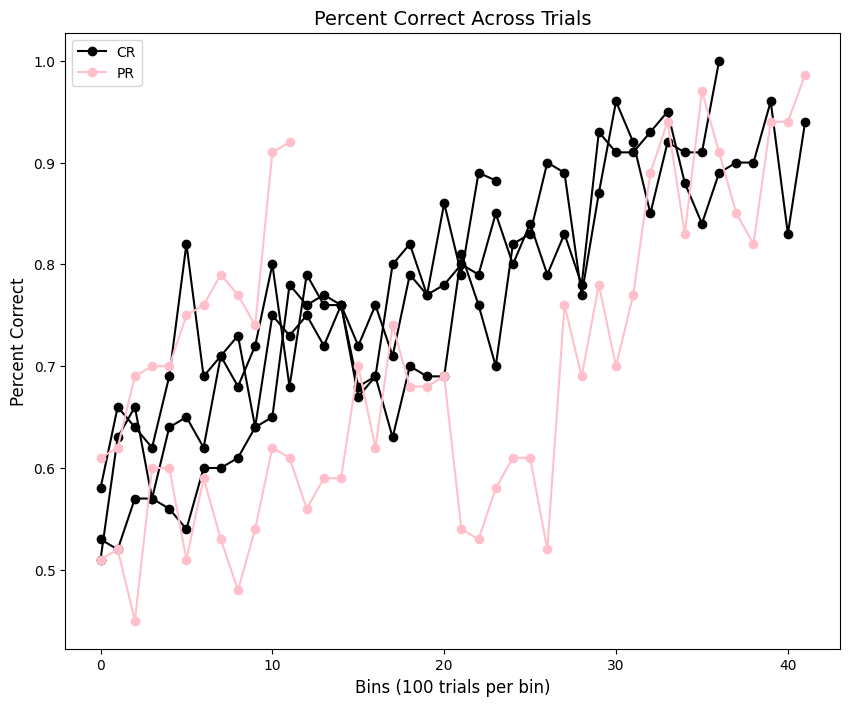

In [213]:
####INDIVIDUAL TRAINING
def parse_stimuli (stimulus):
    stimulus_parser = parse.compile("{foreground}-{sdB:d}_{background}-{snl:d}")
    parse_result = stimulus_parser.parse(stimulus)
    singlemotif = parse_result.named['foreground']
    background = parse_result.named['background']
    sdB = parse_result.named['sdB']
    snl = parse_result.named['snl']
    SNR = snl - sdB
    return singlemotif, sdB, background, snl, SNR

training_plotting_table = pd.DataFrame()
full_responses = pd.DataFrame()
figure, ax = plt.subplots(figsize=(10, 8))
birds = ['C269','C280','C291','C293', 'C294']
rearing = ['CR', 'PR']
leg = {'CR': 'black', 'PR': 'pink'}
binsize = 100

for idx, i in enumerate(birds):
    fulldf = pd.read_csv (i+'.csv')
    mask = fulldf['experiment'].str.contains('training|segmented')
    data = fulldf[mask]
    data = data[data['lights'].isna()]
    smalldf = data[['subject','correct','response','stimulus', 'correction', 'time']]
    SNRdict = smalldf
    motif = []
    background = []
    sdB = []
    snl = []
    SNR = []
    for i in SNRdict['stimulus']:
        info = list(parse_stimuli(i))
        motif.append(info[0])
        sdB.append(info[1])
        background.append(info[2])
        snl.append(info[3])
        SNR.append(info[4])
    SNRdict['Motif'] = motif
    SNRdict['sdB'] = sdB
    SNRdict['Background'] = background
    SNRdict['snl'] = snl
    SNRdict['SNR'] = SNR
    tracker = True
    SNRdict['FIRST_TRY']=0
    for index, trial  in SNRdict[::-1].iterrows(): # This condition has to come first:
        if trial.correction == 0:
            tracker = True
    # So that these can be evaluated correctly
        if (trial['correction']==0) & (trial['response']!='timeout')& (trial['response']!= 'peck_center'):
            SNRdict.loc[index, 'FIRST_TRY'] = 1
            tracker = False
        if (trial['correction']!=0) & (trial['response']!='timeout') & (trial['response']!= 'peck_center')& tracker:
            SNRdict.loc[index, 'FIRST_TRY'] = 1
            tracker = False           
    Firsttrialdict = SNRdict[SNRdict.FIRST_TRY == 1]
    Responsedict = Firsttrialdict[Firsttrialdict.response != 'timeout'].reset_index()
    full_responses = full_responses.append(Responsedict)
# ####Add rearing and location data to dataframe. Remove all noise SNRs and silence foreground
bird_metadata = pd.read_csv('behavior_metadata.csv')
Responsedict = full_responses.merge(bird_metadata)
##Create Dataframe that contains percent correct across SNR###
subjects = Responsedict['subject'].unique()
for s in subjects:
    prac_df = Responsedict[Responsedict['subject']==s]
    wonkybin = len(prac_df)%binsize
    num_bins = len(prac_df)//binsize
    count = []
    numcorrect = []
    wonkybinneddata = prac_df.iloc[0:wonkybin]
    trialcount = len(wonkybinneddata.SNR)
    num = len(wonkybinneddata[wonkybinneddata.correct==True])
    count.append(trialcount)
    numcorrect.append(num)

    for i in range(num_bins):
        binneddata = prac_df.iloc[wonkybin+(i)*binsize:wonkybin+(i+1)*binsize]
        trialcount = len(binneddata.SNR)
        num = len(binneddata[binneddata.correct==True])
        count.append(trialcount)
        numcorrect.append(num)

    count = count[::-1]
    numcorrect = numcorrect[::-1]
    analysis={'subject': s,
              'group': prac_df['group'].iloc[0],
              'bin':range(num_bins+1),
          'N':count,
          'Correct':numcorrect,
          }
    analysisdf = pd.DataFrame(analysis)
    analysisdf['PercentCorrect'] = analysisdf['Correct']/analysisdf['N']
    training_plotting_table = training_plotting_table.append(analysisdf)
    if analysisdf['group'].iloc[0] == 'CR':
        c = 'black'
    else:
        c = 'pink'
    plt.plot(analysisdf.bin, analysisdf.PercentCorrect, color = c, marker = 'o')
    plt.xlabel('Bins (100 trials per bin)', fontsize = 12)
    plt.ylabel('Percent Correct', fontsize = 12)
    plt.title("Percent Correct Across Trials",fontsize = 14)
    
    import matplotlib.lines as mlines
    black_line = mlines.Line2D([], [], color='black', marker='o',
                          markersize=6, label='CR')
    pink_line = mlines.Line2D([], [], color='pink', marker='o',
                          markersize=6, label='PR')
    plt.legend(handles = [black_line,pink_line])
    plt.savefig('Individual Training Performance Curves Across Rearing Condition')
    
    

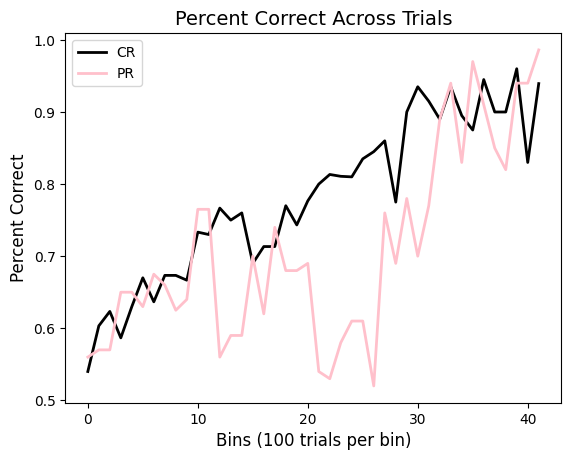

In [214]:
grouped_plots = training_plotting_table.groupby(['group','bin'])['PercentCorrect'].agg('mean').reset_index()
grouped_plots
CR_plot = grouped_plots[grouped_plots['group'] == 'CR']
PR_plot = grouped_plots[grouped_plots['group'] == 'PR']
fig, ax = plt.subplots()
ax1 = plt.plot(CR_plot.bin, CR_plot.PercentCorrect, color = 'Black', linewidth = 2)
ax1 = plt.plot(PR_plot.bin, PR_plot.PercentCorrect, color = 'Pink', linewidth = 2)
plt.legend(['CR', 'PR'])
plt.xlabel('Bins (100 trials per bin)', fontsize = 12)
plt.ylabel('Percent Correct', fontsize = 12)
plt.title("Percent Correct Across Trials",fontsize = 14)
plt.savefig('Average Training Performance Curves Across Rearing Condition')

In [58]:
####PRETRAIN RESPONSES
birds = ['C269','C280','C291', 'C235', 'C293', 'C294','C250', 'C193', 'C191']
for idx, i in enumerate(birds):
    fulldf = pd.read_csv (i+'.csv')
    mask = fulldf['experiment'].str.contains('pretrain|shaping')
    data = fulldf[mask]
    print(data.subject.unique(),data.response.unique())

['C269'] ['peck_left' 'peck_right' 'timeout' 'peck_center']
['C280'] ['peck_left' 'peck_right' 'timeout']
['C291'] ['peck_right' 'peck_left' 'timeout']
['C235'] ['timeout' 'peck_right' 'peck_left' 'peck_center']
['C293'] ['peck_right' 'peck_left' 'timeout' 'peck_center']
['C294'] ['timeout' 'peck_left' 'peck_right']
['C250'] ['timeout' 'peck_left' 'peck_right' 'peck_center']
['C193'] ['timeout' 'peck_left' 'peck_right']
['C191'] ['timeout' 'peck_left' 'peck_right']


In [231]:
birds = ['C269','C280','C291','C293', 'C294']
for idx, i in enumerate(birds):
    fulldf = pd.read_csv (i+'.csv')
    mask = fulldf['experiment'].str.contains('training|segmented')
    data = fulldf[mask]
    print(data.subject.unique(),data.response.unique())

['C269'] ['peck_left' 'peck_right' 'timeout']
['C280'] ['peck_right' 'peck_left' 'timeout']
['C291'] ['peck_left' 'peck_right' 'timeout']
['C293'] ['peck_right' 'peck_left' 'timeout']
['C294'] ['peck_left' 'timeout' 'peck_right']


/tmp/ipykernel_219392/4222426128.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_219392/4222426128.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_219392/4222426128.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

AttributeError: 'DataFrame' object has no attribute 'append'

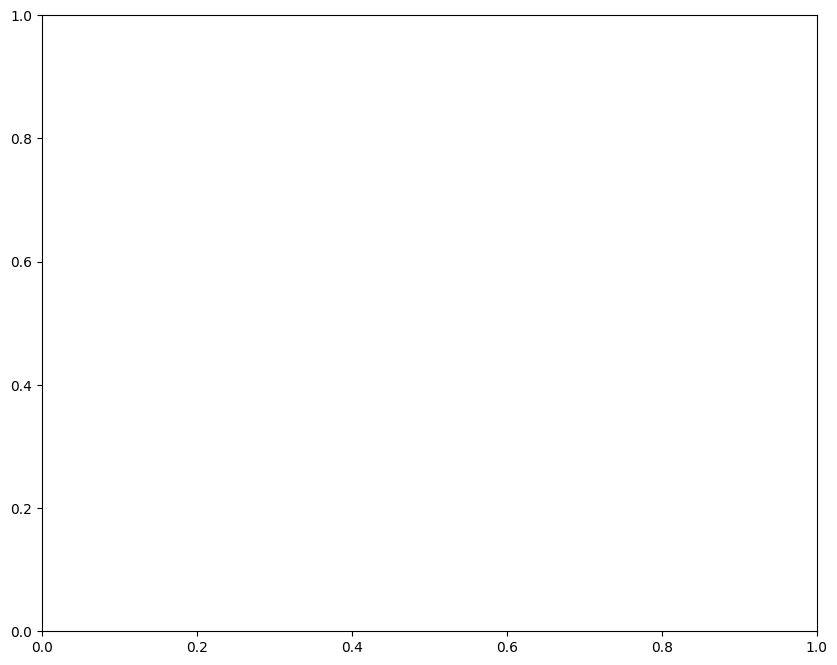

In [32]:
####CALCULTATING TOTAL TRIALS PER BIRD
def parse_pretrain_stimuli (stimulus):
    stimulus_parser = parse.compile("{foreground}_{sdB:d}")
    parse_result = stimulus_parser.parse(stimulus)
    singlemotif = parse_result.named['foreground']
    sdB = parse_result.named['sdB']
    SNR = 70
    return singlemotif, sdB, SNR

figure, ax = plt.subplots(figsize=(10, 8))
birds = ['C269','C280','C291', 'C235', 'C293', 'C294','C250', 'C193', 'C191']
rearing = ['CR', 'PR']
leg = {'CR': 'black', 'PR': 'blue'}
binsize = 100
subject = []
total_trials = []
group = []
for idx, i in enumerate(birds):
    full_responses = pd.DataFrame()
    fulldf = pd.read_csv (i+'.csv')
    mask = fulldf['experiment'].str.contains('pretrain|shaping')
    data = fulldf[mask].reset_index()
    lengthdata = len(data)
    lightsdata = data[data['lights'].isna()]
    smalldf = lightsdata[['subject','correct','response','stimulus', 'correction', 'time']]
    SNRdict = smalldf
    motif = []
    sdB = []
    SNR = []
    for i in SNRdict['stimulus']:
        info = list(parse_pretrain_stimuli(i))
        motif.append(info[0])
        sdB.append(info[1])
        SNR.append(info[2])

    SNRdict['Motif'] = motif
    SNRdict['sdB'] = sdB
    SNRdict['SNR'] = SNR
    
    tracker = True
    SNRdict['FIRST_TRY']=0
    for index, trial  in SNRdict[::-1].iterrows(): # This condition has to come first:
        if trial.correction == 0:
            tracker = True
    # So that these can be evaluated correctly
        if (trial['correction']==0) & (trial['response']!='timeout') & (trial['response']!= 'peck_center'):
            SNRdict.loc[index, 'FIRST_TRY'] = 1
            tracker = False
        if (trial['correction']!=0) & (trial['response']!='timeout') & (trial['response']!= 'peck_center')& tracker:
            SNRdict.loc[index, 'FIRST_TRY'] = 1
            tracker = False           
    Firsttrialdict = SNRdict[SNRdict.FIRST_TRY == 1]
    response = Firsttrialdict[Firsttrialdict.response != 'timeout'].reset_index()
    full_responses = full_responses.append(response)
    bird_metadata = pd.read_csv('behavior_metadata.csv')
    Responsedict = full_responses.merge(bird_metadata)
    #Create Dataframe that contains percent correct across SNR###
    subjects = Responsedict['subject'].unique()
    s = subjects[0]
    prac_df = Responsedict[Responsedict['subject']==s]
    rearing = prac_df.group.unique()
    group.append(rearing[0])
    wonkybin = len(prac_df)%binsize
    num_bins = len(prac_df)//binsize
    count = []
    numcorrect = []
    wonkybinneddata = prac_df.iloc[0:wonkybin]
    trialcount = len(wonkybinneddata.SNR)
    num = len(wonkybinneddata[wonkybinneddata.correct==True])
    count.append(trialcount)
    numcorrect.append(num)


    for i in range(num_bins):
        binneddata = prac_df.iloc[wonkybin+(i)*binsize:wonkybin+(i+1)*binsize]
        trialcount = len(binneddata.SNR)
        num = len(binneddata[binneddata.correct==True])
        count.append(trialcount)
        numcorrect.append(num)

    count = count[::-1]
    numcorrect = numcorrect[::-1]
    analysis={'bin':range(num_bins+1),
          'N':count,
          'Correct':numcorrect,
          }

    analysisdf = pd.DataFrame(analysis)
    analysisdf['PercentCorrect'] = analysisdf['Correct']/analysisdf['N']
    index = (analysisdf['PercentCorrect'] >= .8).idxmax()
    trialnumber = index * binsize
    trial = Responsedict.iloc[[trialnumber],[0]].reset_index(drop = True)
    trialtime= (trial['index'][0])
    totaltrials = lengthdata - trialtime
    subject.append(s)
    total_trials.append(totaltrials)

data_description = pd.DataFrame({'subjects': birds,
                    'total_trials': total_trials,
                   'group': group})
# sns.boxplot(x = group, y = total_trials)

In [60]:
data_description

,subjects,total_trials,group
0,C269,6067,CR
1,C280,3633,CR
2,C291,7203,CR
3,C235,7033,CR
4,C293,16202,PR
5,C294,11600,PR
6,C250,11275,PR
7,C193,4606,PR
8,C191,8194,PR


In [31]:
####PLOTTING TOTAL TRIALS
data_description
figure, ax = plt.subplots(figsize=(10, 8))
means = data_description.groupby(['group']).agg(['mean', 'std','sem']).reset_index()
means.columns = ['group', 'mean','std', 'sem']
plt.bar(means['group'], means['mean'], yerr= means['sem'], color = ['grey', 'pink'])
plt.xlabel('Rearing', fontsize = 14)
plt.ylabel('Total Trials', fontsize = 14)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

NameError: name 'data_description' is not defined

C269
6981


/tmp/ipykernel_2104427/4233161661.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_2104427/4233161661.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_2104427/4233161661.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

   subject group  bin    N  Timeout  PercentTimeout
0     C269    CR    0  500      274           0.548
1     C269    CR    1  500      219           0.438
2     C269    CR    2  500      148           0.296
3     C269    CR    3  500       82           0.164
4     C269    CR    4  500      146           0.292
5     C269    CR    5  500      131           0.262
6     C269    CR    6  500      124           0.248
7     C269    CR    7  500      129           0.258
8     C269    CR    8  500      238           0.476
9     C269    CR    9  500      117           0.234
10    C269    CR   10  500       77           0.154
11    C269    CR   11  500      126           0.252
12    C269    CR   12  500      114           0.228
13    C269    CR   13  481        0           0.000
C280
4652


/tmp/ipykernel_2104427/4233161661.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_2104427/4233161661.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_2104427/4233161661.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

   subject group  bin    N  Timeout  PercentTimeout
0     C269    CR    0  500      274           0.548
1     C269    CR    1  500      219           0.438
2     C269    CR    2  500      148           0.296
3     C269    CR    3  500       82           0.164
4     C269    CR    4  500      146           0.292
5     C269    CR    5  500      131           0.262
6     C269    CR    6  500      124           0.248
7     C269    CR    7  500      129           0.258
8     C269    CR    8  500      238           0.476
9     C269    CR    9  500      117           0.234
10    C269    CR   10  500       77           0.154
11    C269    CR   11  500      126           0.252
12    C269    CR   12  500      114           0.228
13    C269    CR   13  481        0           0.000
0     C280    CR    0  500      265           0.530
1     C280    CR    1  500      253           0.506
2     C280    CR    2  500      257           0.514
3     C280    CR    3  500      364           0.728
4     C280  

/tmp/ipykernel_2104427/4233161661.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_2104427/4233161661.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_2104427/4233161661.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

   subject group  bin    N  Timeout  PercentTimeout
0     C269    CR    0  500      274           0.548
1     C269    CR    1  500      219           0.438
2     C269    CR    2  500      148           0.296
3     C269    CR    3  500       82           0.164
4     C269    CR    4  500      146           0.292
5     C269    CR    5  500      131           0.262
6     C269    CR    6  500      124           0.248
7     C269    CR    7  500      129           0.258
8     C269    CR    8  500      238           0.476
9     C269    CR    9  500      117           0.234
10    C269    CR   10  500       77           0.154
11    C269    CR   11  500      126           0.252
12    C269    CR   12  500      114           0.228
13    C269    CR   13  481        0           0.000
0     C280    CR    0  500      265           0.530
1     C280    CR    1  500      253           0.506
2     C280    CR    2  500      257           0.514
3     C280    CR    3  500      364           0.728
4     C280  

/tmp/ipykernel_2104427/4233161661.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_2104427/4233161661.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_2104427/4233161661.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

   subject group  bin    N  Timeout  PercentTimeout
0     C269    CR    0  500      274           0.548
1     C269    CR    1  500      219           0.438
2     C269    CR    2  500      148           0.296
3     C269    CR    3  500       82           0.164
4     C269    CR    4  500      146           0.292
5     C269    CR    5  500      131           0.262
6     C269    CR    6  500      124           0.248
7     C269    CR    7  500      129           0.258
8     C269    CR    8  500      238           0.476
9     C269    CR    9  500      117           0.234
10    C269    CR   10  500       77           0.154
11    C269    CR   11  500      126           0.252
12    C269    CR   12  500      114           0.228
13    C269    CR   13  481        0           0.000
0     C280    CR    0  500      265           0.530
1     C280    CR    1  500      253           0.506
2     C280    CR    2  500      257           0.514
3     C280    CR    3  500      364           0.728
4     C280  

/tmp/ipykernel_2104427/4233161661.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_2104427/4233161661.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_2104427/4233161661.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

   subject group  bin    N  Timeout  PercentTimeout
0     C269    CR    0  500      274           0.548
1     C269    CR    1  500      219           0.438
2     C269    CR    2  500      148           0.296
3     C269    CR    3  500       82           0.164
4     C269    CR    4  500      146           0.292
..     ...   ...  ...  ...      ...             ...
28    C293    PR   28  500      305           0.610
29    C293    PR   29  500      337           0.674
30    C293    PR   30  500      248           0.496
31    C293    PR   31  500      238           0.476
32    C293    PR   32  202        0           0.000

[89 rows x 6 columns]
C294
12198


/tmp/ipykernel_2104427/4233161661.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_2104427/4233161661.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_2104427/4233161661.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

   subject group  bin    N  Timeout  PercentTimeout
0     C269    CR    0  500      274           0.548
1     C269    CR    1  500      219           0.438
2     C269    CR    2  500      148           0.296
3     C269    CR    3  500       82           0.164
4     C269    CR    4  500      146           0.292
..     ...   ...  ...  ...      ...             ...
20    C294    PR   20  500      300           0.600
21    C294    PR   21  500      345           0.690
22    C294    PR   22  500      275           0.550
23    C294    PR   23  500      127           0.254
24    C294    PR   24  198        0           0.000

[114 rows x 6 columns]
C250
12058


/tmp/ipykernel_2104427/4233161661.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_2104427/4233161661.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_2104427/4233161661.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

   subject group  bin    N  Timeout  PercentTimeout
0     C269    CR    0  500      274           0.548
1     C269    CR    1  500      219           0.438
2     C269    CR    2  500      148           0.296
3     C269    CR    3  500       82           0.164
4     C269    CR    4  500      146           0.292
..     ...   ...  ...  ...      ...             ...
20    C250    PR   20  500      290           0.580
21    C250    PR   21  500      324           0.648
22    C250    PR   22  500      278           0.556
23    C250    PR   23  500      284           0.568
24    C250    PR   24   58        0           0.000

[139 rows x 6 columns]
C193
5955


/tmp/ipykernel_2104427/4233161661.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_2104427/4233161661.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_2104427/4233161661.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

   subject group  bin    N  Timeout  PercentTimeout
0     C269    CR    0  500      274           0.548
1     C269    CR    1  500      219           0.438
2     C269    CR    2  500      148           0.296
3     C269    CR    3  500       82           0.164
4     C269    CR    4  500      146           0.292
..     ...   ...  ...  ...      ...             ...
7     C193    PR    7  500      167           0.334
8     C193    PR    8  500      280           0.560
9     C193    PR    9  500      198           0.396
10    C193    PR   10  500      315           0.630
11    C193    PR   11  455        0           0.000

[151 rows x 6 columns]
C191
9510


/tmp/ipykernel_2104427/4233161661.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_2104427/4233161661.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_2104427/4233161661.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

   subject group  bin    N  Timeout  PercentTimeout
0     C269    CR    0  500      274           0.548
1     C269    CR    1  500      219           0.438
2     C269    CR    2  500      148           0.296
3     C269    CR    3  500       82           0.164
4     C269    CR    4  500      146           0.292
..     ...   ...  ...  ...      ...             ...
15    C191    PR   15  500      365           0.730
16    C191    PR   16  500      386           0.772
17    C191    PR   17  500      416           0.832
18    C191    PR   18  500      384           0.768
19    C191    PR   19   10        0           0.000

[171 rows x 6 columns]


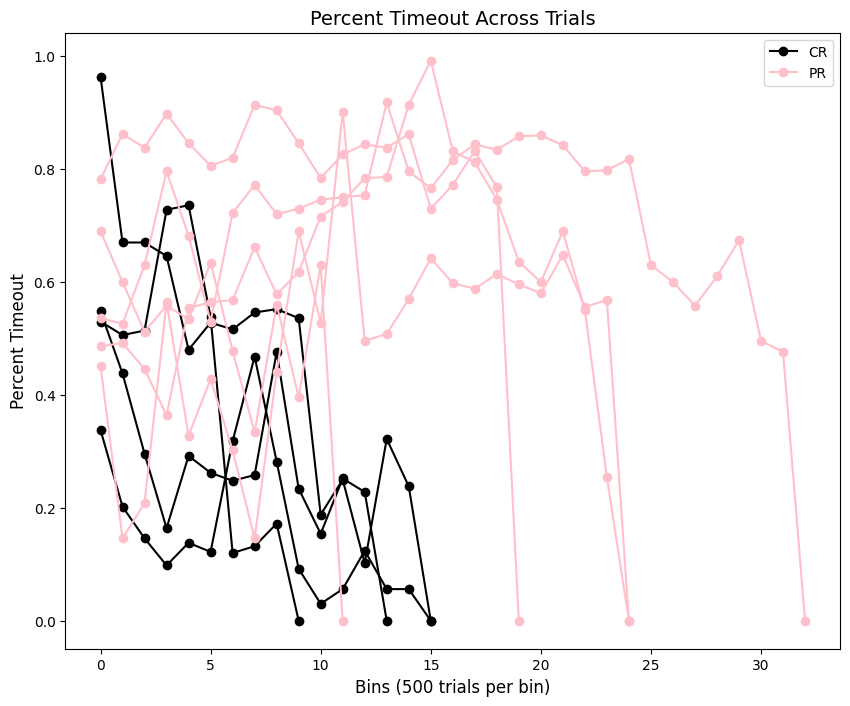

In [65]:
####CALCULTATING TIMEOUTS PER BIRD
def parse_pretrain_stimuli (stimulus):
    stimulus_parser = parse.compile("{foreground}_{sdB:d}")
    parse_result = stimulus_parser.parse(stimulus)
    singlemotif = parse_result.named['foreground']
    sdB = parse_result.named['sdB']
    SNR = 70
    return singlemotif, sdB, SNR

training_plotting_table = pd.DataFrame()
figure, ax = plt.subplots(figsize=(10, 8))
birds = ['C269','C280','C291', 'C235', 'C293', 'C294','C250', 'C193', 'C191']
rearing = ['CR', 'PR']
leg = {'CR': 'black', 'PR': 'blue'}
binsize = 500
subject = []
total_trials = []
group = []
for idx, b in enumerate(birds):
    print(b)
    full_responses = pd.DataFrame()
    fulldf = pd.read_csv (b+'.csv')
    mask = fulldf['experiment'].str.contains('pretrain|shaping')
    data = fulldf[mask].reset_index()
    lengthdata = len(data)
    print(lengthdata)
    smalldf = data[['subject','correct','response','stimulus', 'correction', 'time']]
    SNRdict = smalldf
    motif = []
    sdB = []
    SNR = []
    for s in SNRdict['stimulus']:
        info = list(parse_pretrain_stimuli(s))
        motif.append(info[0])
        sdB.append(info[1])
        SNR.append(info[2])

    SNRdict['Motif'] = motif
    SNRdict['sdB'] = sdB
    SNRdict['SNR'] = SNR
    
    bird_metadata = pd.read_csv('behavior_metadata.csv')
    Responsedict = SNRdict.merge(bird_metadata)
    #Create Dataframe that contains percent correct across SNR###
    subjects = Responsedict['subject'].unique()
    s = subjects[0]
    rearing = Responsedict.group.unique()
    group.append(rearing[0])
    wonkybin = len(Responsedict)%binsize
    num_bins = len(Responsedict)//binsize
    count = []
    numtimeout = []
    wonkybinneddata = Responsedict.iloc[0:wonkybin]
    trialcount = len(wonkybinneddata.SNR)
    num = len(wonkybinneddata[wonkybinneddata.response=='=timeout'])
    count.append(trialcount)
    numtimeout.append(num)
    
    for i in range(num_bins):
        binneddata = Responsedict.iloc[wonkybin+(i)*binsize:wonkybin+(i+1)*binsize]
        trialcount = len(binneddata.SNR)
        num = len(binneddata[binneddata.response=='timeout'])
        count.append(trialcount)
        numtimeout.append(num)

    count = count[::-1]
    numtimeout = numtimeout[::-1]
    analysis={'subject': s,
              'group': Responsedict['group'].iloc[0],
              'bin':range(num_bins+1),
          'N':count,
          'Timeout':numtimeout,
          }

    analysisdf = pd.DataFrame(analysis)
    analysisdf['PercentTimeout'] = analysisdf['Timeout']/analysisdf['N']
    training_plotting_table = training_plotting_table.append(analysisdf)
    print(training_plotting_table)
    if analysisdf['group'].iloc[0] == 'CR':
        c = 'black'
    else:
        c = 'pink'
    plt.plot(analysisdf.bin, analysisdf.PercentTimeout, color = c, marker = 'o')
    plt.xlabel('Bins (500 trials per bin)', fontsize = 12)
    plt.ylabel('Percent Timeout', fontsize = 12)
    plt.title("Percent Timeout Across Trials",fontsize = 14)
    
    import matplotlib.lines as mlines
    black_line = mlines.Line2D([], [], color='black', marker='o',
                          markersize=6, label='CR')
    pink_line = mlines.Line2D([], [], color='pink', marker='o',
                          markersize=6, label='PR')
    plt.legend(handles = [black_line,pink_line])
    plt.savefig('Individual Timeout Curves Across Rearing Condition')
#     index = (analysisdf['PercentCorrect'] >= .8).idxmax()
#     trialnumber = index * binsize
#     trial = Responsedict.iloc[[trialnumber],[0]].reset_index(drop = True)
#     trialtime= (trial['index'][0])
#     totaltrials = lengthdata - trialtime
#     subject.append(s)
#     total_trials.append(totaltrials)

# data_description = pd.DataFrame({'subjects': birds,
#                     'total_trials': total_trials,
#                    'group': group})

In [8]:
####PRETRAIN Percent Timeout Per Bird
birds = ['C269','C280','C291', 'C235', 'C293', 'C294','C250', 'C193', 'C191']
total_length = []
timeouts = []
for idx, i in enumerate(birds):
    full_responses = pd.DataFrame()
    fulldf = pd.read_csv (i+'.csv')
    mask = fulldf['experiment'].str.contains('pretrain|shaping')
    data = fulldf[mask].reset_index()
    lengthdata = len(data)
    timeout = len(data[data['response'] == 'timeout'])
    total_length.append(lengthdata)
    timeouts.append(timeout)
timeout_description = pd.DataFrame({'subject': birds,
                    'total_trials': total_length,
                   'timeouts': timeouts})
bird_metadata = pd.read_csv('behavior_metadata.csv')
timeout_description = timeout_description.merge(bird_metadata)
timeout_description['percent_timeout'] = timeout_description['timeouts']/timeout_description['total_trials']
timeout_description

,subject,total_trials,timeouts,group,sex,percent_timeout
0,C269,6981,2011,CR,F,0.288068
1,C280,4652,2005,CR,M,0.430997
2,C291,7774,3650,CR,F,0.469514
3,C235,7601,1266,CR,M,0.166557
4,C293,16202,11531,PR,F,0.711702
5,C294,12198,7725,PR,M,0.633301
6,C250,12058,6084,PR,F,0.504561
7,C193,5955,3273,PR,M,0.549622
8,C191,9511,7894,PR,F,0.829986


Text(0, 0.5, 'Percent Timeout')

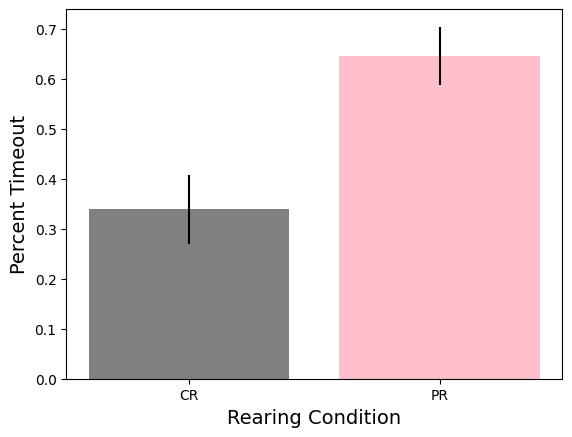

In [30]:
timeoutplot = timeout_description.groupby(['group']).agg({'percent_timeout':['mean','std','sem']}).reset_index()
timeoutplot.columns = ['group','mean','std','sem']
plt.bar(timeoutplot['group'],timeoutplot['mean'], yerr = timeoutplot['sem'], color = ['grey','pink'])
plt.xlabel('Rearing Condition', fontsize = 14)
plt.ylabel('Percent Timeout', fontsize = 14)

In [ ]:
####INDIVIDUAL PLOT

In [352]:
minidf = pd.read_csv ('C193.csv')
print(minidf.experiment.unique())

['2ac-pretrain-setAll-invertedYes']


/tmp/ipykernel_1959539/908765943.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['Motif'] = motif
/tmp/ipykernel_1959539/908765943.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNRdict['sdB'] = sdB
/tmp/ipykernel_1959539/908765943.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

   index subject  correct    response     stimulus  correction  \
3      4    C193     True   peck_left  dhhon79k_30           0   
4      5    C193     True  peck_right  pmkimwop_30           0   
6      9    C193     True  peck_right  pmkimwop_30           0   
7     10    C193     True   peck_left  dhhon79k_30           0   
8     11    C193     True   peck_left  dhhon79k_30           1   

                               time     Motif  sdB  SNR  FIRST_TRY  
3  2023-09-26T12:11:26.401054-04:00  dhhon79k   30   70          1  
4  2023-09-26T12:10:56.079053-04:00  pmkimwop   30   70          1  
6  2023-09-26T12:06:40.486253-04:00  pmkimwop   30   70          1  
7  2023-09-26T12:06:12.346089-04:00  dhhon79k   30   70          1  
8  2023-09-26T12:02:22.928854-04:00  dhhon79k   30   70          1  
(1758, 11)
{'bin': range(0, 18), 'N': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 58], 'Correct': [56, 57, 47, 67, 77, 91, 85, 72, 90, 84, 83, 80, 

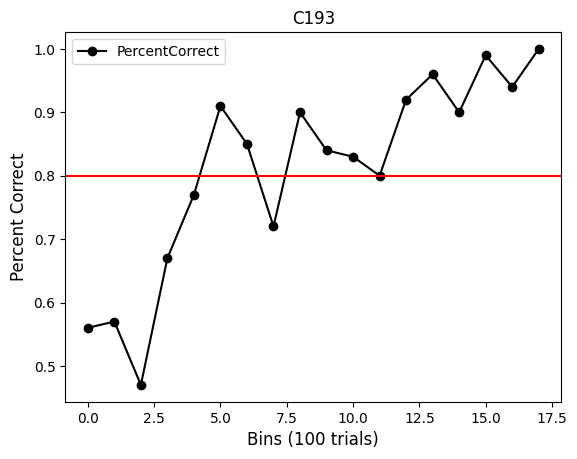

In [353]:
minidf = pd.read_csv ('C193.csv')
#data = minidf[(minidf.experiment == '2ac-shaping-setAll-invertedYes') | (minidf.experiment == '2ac-shaping-setAll-invertedYes-centerNo')]
data = minidf[minidf['experiment']== '2ac-pretrain-setAll-invertedYes']
data = data[data['lights'].isna()]
smalldf = data[['subject','correct','response','stimulus', 'correction', 'time']]
smalldf

SNRdict = smalldf
motif = []
sdB = []
SNR = []

def parse_stimuli (stimulus):
    stimulus_parser = parse.compile("{foreground}_{sdB:d}")
    parse_result = stimulus_parser.parse(stimulus)
    singlemotif = parse_result.named['foreground']
    sdB = parse_result.named['sdB']
    SNR = 70
    return singlemotif, sdB, SNR

for i in SNRdict['stimulus']:
    info = list(parse_stimuli(i))
    motif.append(info[0])
    sdB.append(info[1])
    SNR.append(info[2])

SNRdict['Motif'] = motif
SNRdict['sdB'] = sdB
SNRdict['SNR'] = SNR

tracker = True
subjects = SNRdict['subject'].unique()
first_try_df = pd.DataFrame()
for i in subjects:
    minigrb =  SNRdict[SNRdict.subject==i].reset_index()
    minigrb['FIRST_TRY']=0
    for index, trial  in minigrb[::-1].iterrows(): # This condition has to come first:
        if trial.correction == 0:
            tracker = True
        # So that these can be evaluated correctly
        if (trial['correction']==0) & (trial['response']!='timeout') & (trial['response']!= 'peck_center'):
            minigrb.loc[index, 'FIRST_TRY'] = 1
            tracker = False
        if (trial['correction']!=0) & (trial['response']!='timeout') & (trial['response']!= 'peck_center')& tracker:
            minigrb.loc[index, 'FIRST_TRY'] = 1
            tracker = False 
    first_try_df =  first_try_df.append(minigrb)
first_try_df

Firsttrialdict = first_try_df[first_try_df.FIRST_TRY == 1]
###Remove timeout trials###
Responsedict = Firsttrialdict[Firsttrialdict.response != 'timeout']
print (Responsedict.head())
print (Responsedict.shape)

subjects = Responsedict['subject'].unique()
for s in subjects:
    prac_df = Responsedict[Responsedict['subject']==s]
    wonkybin = len(prac_df)%100
    num_bins = len(prac_df)//100
    count = []
    numcorrect = []
    wonkybinneddata = prac_df.iloc[0:wonkybin]
    trialcount = len(wonkybinneddata.SNR)
    num = len(wonkybinneddata[wonkybinneddata.correct==True])
    count.append(trialcount)
    numcorrect.append(num)


    for i in range(num_bins):
        binneddata = prac_df.iloc[wonkybin+(i)*100:wonkybin+(i+1)*100]
        trialcount = len(binneddata.SNR)
        num = len(binneddata[binneddata.correct==True])
        count.append(trialcount)
        numcorrect.append(num)

    count = count[::-1]
    numcorrect = numcorrect[::-1]
    analysis={'bin':range(num_bins+1),
          'N':count,
          'Correct':numcorrect,
          }

    print (analysis)
    analysisdf = pd.DataFrame(analysis)
    analysisdf['PercentCorrect'] = analysisdf['Correct']/analysisdf['N']
    analysisdf

    analysisdf.plot(x ='bin', y='PercentCorrect', kind = 'line', color = 'black', marker = 'o')
    plt.ylabel('Percent Correct', size = 12)
    plt.xlabel('Bins (100 trials)', size = 12)
    plt.axhline(y = 0.8, color = 'r', linestyle = '-')
    plt.title(s)